<h1>Next Word Prediction using Deep Learning</h1>
- Kashish

<h3>Problem Statement</h3>
We are given an incomplete sentence, we want to build a Deep Learning System that could predict next word in a way that it seems like a human made that sentence.


<h5>Data</h5>
Our data is an aerospace guidelines data.

<h5>Data Sample</h5>
 'ops part 1 prescribes requirements applicable to the operation of any civil     aeroplane for the purpose of commercial air transportation by any operator whose principal place of business and, if any, registered office is in a member state, hereafter called operator.',
 'ops 1 does not apply:',
 'to aeroplanes when used in military, customs and police services; nor',
 'to parachute dropping and fire-fighting flights, and to associated positioning and return flights in which the persons carried are those who would normally be carried on parachute dropping or fire-fighting; nor',

In [30]:
raw_data=open('../Next_Word_Prediction/50klines.txt',encoding='utf-8').read()
raw_data=raw_data.lower().split('\n')[:-25000]
raw_data[0:2]

['ops part 1 prescribes requirements applicable to the operation of any civil aeroplane for the purpose of commercial air transportation by any operator whose principal place of business and, if any, registered office is in a member state, hereafter called operator.',
 'ops 1 does not apply:']

<h5>Data Preprocessing and Exploratiry Data Analysis</h5>
<li>Remove punctuations
<li>Count no. of lines
<li>Count no. of unique words
<li>Find min and max length of a sentence

In [31]:

from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer


In [32]:
#remove punctuations
raw_data=[s.translate(str.maketrans('','',punctuation)) for s in raw_data]
#count number of lines in datafile
print('Number of lines in dataset : {}'.format(len(raw_data)))
#count number of unique words in dataset
tokenizer=Tokenizer()
tokenizer.fit_on_texts(raw_data)
print('Number of unique words in dataset : {}'.format(len(tokenizer.word_index)))
#find minimum and maximum number of words in a sentence
tokenized_data=tokenizer.texts_to_sequences(raw_data)
lines_length=[len(sentence) for sentence in tokenized_data]
print('Max length of a Sentence : {}\nMin length of a Sentence : {}'.format(max(lines_length),min(lines_length)))

Number of lines in dataset : 25021
Number of unique words in dataset : 16829
Max length of a Sentence : 313
Min length of a Sentence : 1


In [33]:
from pandas import DataFrame
from seaborn import displot
from matplotlib.pyplot import grid

In [34]:
temp_df=DataFrame({'n_lines':lines_length})
temp_df=temp_df.n_lines.value_counts().reset_index()

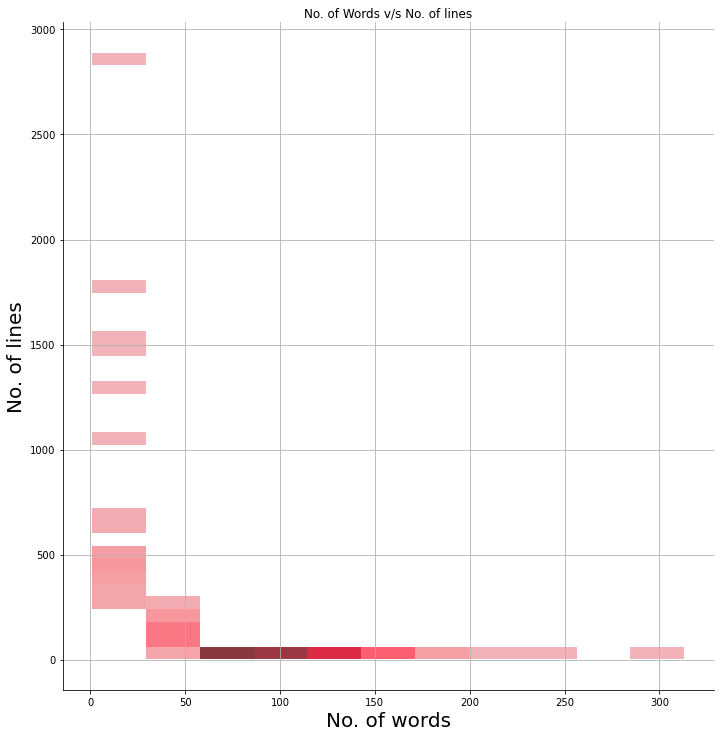

In [35]:
displot(y=temp_df.iloc[:,1],x=temp_df.iloc[:,0],aspect=1,height=10,color='crimson',kind='hist').set(title='No. of Words v/s No. of lines').set_axis_labels('No. of words','No. of lines',fontsize=20)
grid(True)

From the plot we can infer that most no. of lines have few words and very small no. of lines have more than 50 words in one line.

<h3>Preprare the data to feed to model for training

<h5>Create N-grams

In [36]:
training_sequences=[sequence[:i] for sequence in tokenized_data for i in range(2,len(sequence)+1)]

<h5>Padding the data with zeros

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences=pad_sequences(training_sequences)

In [38]:
#prepare the training data
x_train,y_train=padded_sequences[:,:-1],padded_sequences[:,-1]

<h3>Defining and Training the Model</h5>
We are using a Sequential model

In [67]:
#setting the parameters for model with Bidrectional LSTM and LSTM layers
vocab_size=len(tokenizer.word_index)+1
wv_dims=10
input_length=x_train.shape[1]
dropout_rate=0.2
lstm_units=128
regularization_rate=0.01
epochs=50

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense,Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint

In [73]:
model=Sequential()
model.add(Embedding(vocab_size,wv_dims,input_length=100))
# model.add(Bidirectional(LSTM(64,return_sequences=True)))
# model.add(Dropout(dropout_rate))
# model.add(LSTM(64))
model.add(LSTM(64,return_sequences=True))
model.add(Dense(100,activation='relu',activity_regularizer=L2(regularization_rate)))
model.add(Dense(vocab_size,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint=ModelCheckpoint('../Next_Word_Prediction/nw_model_bidrec_LSTM.best.hdf5',monitor='accuracy',save_best_only=True,mode='max')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 10)           168300    
                                                                 
 lstm_29 (LSTM)              (None, 100, 64)           19200     
                                                                 
 dense_40 (Dense)            (None, 100, 100)          6500      
                                                                 
 dense_41 (Dense)            (None, 100, 16830)        1699830   
                                                                 
Total params: 1,893,830
Trainable params: 1,893,830
Non-trainable params: 0
_________________________________________________________________


In [75]:
#training the model
history=model.fit(x_train,y_train,epochs=1,batch_size=64,verbose=1,callbacks=[checkpoint],use_multiprocessing=False)

ValueError: in user code:

    File "D:\Installations\Anaconda\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "D:\Installations\Anaconda\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Installations\Anaconda\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "D:\Installations\Anaconda\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "D:\Installations\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Installations\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_20" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 312)
